This notebook covers portfolio optimization.

In this notebook, we will:

1. View the $\frac{1}{n}$ portfolio (or equal-weighted portfolio) 
1. Use SciPy's `minimize()` function to:
    1. Find the minimum variance portfolio
    1. Find the (mean-variance) efficient frontier

In the practice notebook, we will use SciPy's `minimize()` function to achieve any objective.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
%config InlineBackend.figure_format = 'retina'
%precision 4
pd.options.display.float_format = '{:.4f}'.format

In [3]:
import yfinance as yf
import pandas_datareader as pdr
import requests_cache
session = requests_cache.CachedSession()

## The $\frac{1}{n}$ Portfolio

We first saw the $\frac{1}{n}$ portfolio (or equal-weighted portfolio) in [Herron Topic 1](herron_01_lecture.ipynb).
In the $\frac{1}{n}$ portfolio, each of $n$ assets receives an equal portfolio weight $w_i = \frac{1}{n}$.
While the $\frac{1}{n}$ strategy seems too simple to be useful, DeMiguel, Garlappi, and Uppal (2007) show that it is difficult to beat $\frac{1}{n}$ strategy, even with more advanced strategies.

In [4]:
tickers = 'MSFT AAPL TSLA AMZN NVDA GOOG'

matana = (
    yf.download(tickers=tickers, progress=False)
    .assign(Date=lambda x: x.index.tz_localize(None))
    .set_index('Date')
    .rename_axis(columns=['Variable', 'Ticker'])
)

matana.tail()

Variable   Adj Close                                                 Close  \
Ticker          AAPL     AMZN     GOOG     MSFT     NVDA     TSLA     AAPL   
Date                                                                         
2023-03-20  157.4000  97.7100 101.9300 272.2300 259.0000 183.2500 157.4000   
2023-03-21  159.2800 100.6100 105.8400 273.7800 261.9900 197.5800 159.2800   
2023-03-22  157.8300  98.7000 104.2200 272.2900 264.6800 191.1500 157.8300   
2023-03-23  158.9300  98.7100 106.2600 277.6600 271.9100 192.2200 158.9300   
2023-03-24  158.9300  97.4100 105.6050 278.5400 266.2550 189.4000 158.9300   

Variable                               ...     Open                    \
Ticker         AMZN     GOOG     MSFT  ...     GOOG     MSFT     NVDA   
Date                                   ...                              
2023-03-20  97.7100 101.9300 272.2300  ... 101.0600 276.9800 256.1500   
2023-03-21 100.6100 105.8400 273.7800  ... 101.9800 274.8800 261.8000   
2023-03-22  98.7000 104.2200 272.2900  ... 105.1400 273.4000 264.2500   
2023-03-23  98.7100 106.2600 277.6600  ... 105.8900 277.9400 271.1500   
2023-03-24  97.4100 105.6050 278.5400  ... 105.7400 277.2400 270.3100   

Variable               Volume                                            \
Ticker         TSLA      AAPL          AMZN          GOOG          MSFT   
Date                                                                      
2023-03-20 178.0800  73641400 62388900.0000 26033900.0000 43466600.0000   
2023-03-21 188.2800  73938300 58597300.0000 33122800.0000 34558700.0000   
2023-03-22 199.3000  75701800 57475400.0000 32336900.0000 34873300.0000   
2023-03-23 195.2600  67572500 57491000.0000 31369800.0000 36590300.0000   
2023-03-24 191.6500  26073408 26008374.0000 12005487.0000 12500555.0000   

Variable                                 
Ticker              NVDA           TSLA  
Date                                     
2023-03-20 43274700.0000 129684400.0000  
2023-03-21 54740800.0000 153391400.0000  
2023-03-22 79729500.0000 150376400.0000  
2023-03-23 56377300.0000 143865300.0000  
2023-03-24 24673779.0000  63328036.0000  

[5 rows x 36 columns]

In [5]:
returns = matana['Adj Close'].pct_change().iloc[(-3 * 252):]

returns.describe()

Ticker,AAPL,AMZN,GOOG,MSFT,NVDA,TSLA
count,756.0000,756.0000,756.0000,756.0000,756.0000,756.0000
mean,0.0015,0.0003,0.0010,0.0011,0.0025,0.0032
std,0.0206,0.0243,0.0207,0.0191,0.0334,0.0421
min,-0.0801,-0.1405,-0.0963,-0.0772,-0.0947,-0.2106
25%,-0.0101,-0.0132,-0.0097,-0.0096,-0.0172,-0.0208
50%,0.0012,0.0005,0.0015,0.0007,0.0032,0.0021
75%,0.0141,0.0127,0.0117,0.0120,0.0230,0.0251
max,0.1047,0.1354,0.0874,0.0823,0.1433,0.1964


Before we revisit the advanced techniques from [Herron Topic 1](herron_01_lecture), we can calculate $\frac{1}{n}$ portfolio returns manually, where $R_P = \frac{\sum_{i}^{n} R_i}{n}$
Since our weights are constant (i.e., do not change over time), we rebalance our portfolio every return period.
If we have daily data, rebalance daily.
If we have monthly data, we rebalance monthly, and so on.

In [6]:
n = returns.shape[1]
p1 = returns.sum(axis=1).div(n)

p1.describe()

count   756.0000
mean      0.0016
std       0.0218
min      -0.0782
25%      -0.0113
50%       0.0021
75%       0.0149
max       0.0980
dtype: float64

Recall from [Herron Topic 1](herron_01_lecture) we have two better options:

1. The `.mean(axis=1)` method for the $\frac{1}{n}$ portfolio
1. The `.dot(weights)` method where `weights` is a pandas series or NumPy array of portfolio weights, allowing different weights for each asset

In [7]:
p2 = returns.mean(axis=1)

p2.describe()

count   756.0000
mean      0.0016
std       0.0218
min      -0.0782
25%      -0.0113
50%       0.0021
75%       0.0149
max       0.0980
dtype: float64

In [8]:
weights = np.ones(n) / n
p3 = returns.dot(weights)

p3.describe()

count   756.0000
mean      0.0016
std       0.0218
min      -0.0782
25%      -0.0113
50%       0.0021
75%       0.0149
max       0.0980
dtype: float64

The `.describe()` method provides summary statistics for data, letting us make quick comparisons.
However, we should use `np.allclose()` if we want to be sure that `p1`, `p2`, and `p3` are similar.

In [9]:
np.allclose(p1, p2)

True

In [10]:
np.allclose(p1, p3)

True

---

Here is a simple example to help understand the `.dot()` method.

In [11]:
silly_n = 3
silly_R = pd.DataFrame(np.arange(2*silly_n).reshape(2, silly_n))
silly_w = np.ones(3) / 3

In [12]:
print(
    f'silly_n:\n{silly_n}',
    f'silly_R:\n{silly_R}',
    f'silly_w:\n{silly_w}',
    sep='\n\n'
)

silly_n:
3

silly_R:
   0  1  2
0  0  1  2
1  3  4  5

silly_w:
[0.3333 0.3333 0.3333]


In [13]:
silly_R.dot(silly_w)

0   1.0000
1   4.0000
dtype: float64

Under the hood, Python and the `.dot()` method (effectively) do the following calculation:

In [14]:
for i, row in silly_R.iterrows():
    print(
        f'Row {i}: ',
        ' + '.join([f'{w:0.2f} * {y}' for w, y in zip(silly_w, row)]),
        ' = ',
        f'{silly_R.dot(silly_w).iloc[i]:0.2f}'
    )

Row 0:  0.33 * 0 + 0.33 * 1 + 0.33 * 2  =  1.00
Row 1:  0.33 * 3 + 0.33 * 4 + 0.33 * 5  =  4.00


---

## SciPy's `minimize()` Function 

### A Crash Course in SciPy's `minimize()` Function

The `minimize()` function from SciPy's `optimize` module finds the input array `x` that minimizes the output of the function `fun`.
The `minimize()` function uses optimization techniques that are outside this course, but you can consider these optimization techniques to be sophisticated trial and error.

Here are the most common arguments we will pass to the `minimize()` function:

1. We pass our first guess for input array `x` to argument `x0=`.
1. We pass additional arguments for function `fun` as a tuple to argument `args=`.
1. We pass lower and upper bounds on `x` as a tuple of tuples to argument `bounds=`.
1. We constrain our results with a tuple of dictionaries of functions to argument `contraints=`.

Here is a simple example that minimizes the function `quadratic()` that accepts arguments `x` and `a` and returns $y = (x - a)^2$.

In [15]:
import scipy.optimize as sco

In [16]:
def quadratic(x, a=5):
    return (x - a) ** 2

In [17]:
quadratic(x=5, a=5)

0

In [18]:
quadratic(x=10, a=5)

25

It is helpful to plot $y = (x - a)$ first.

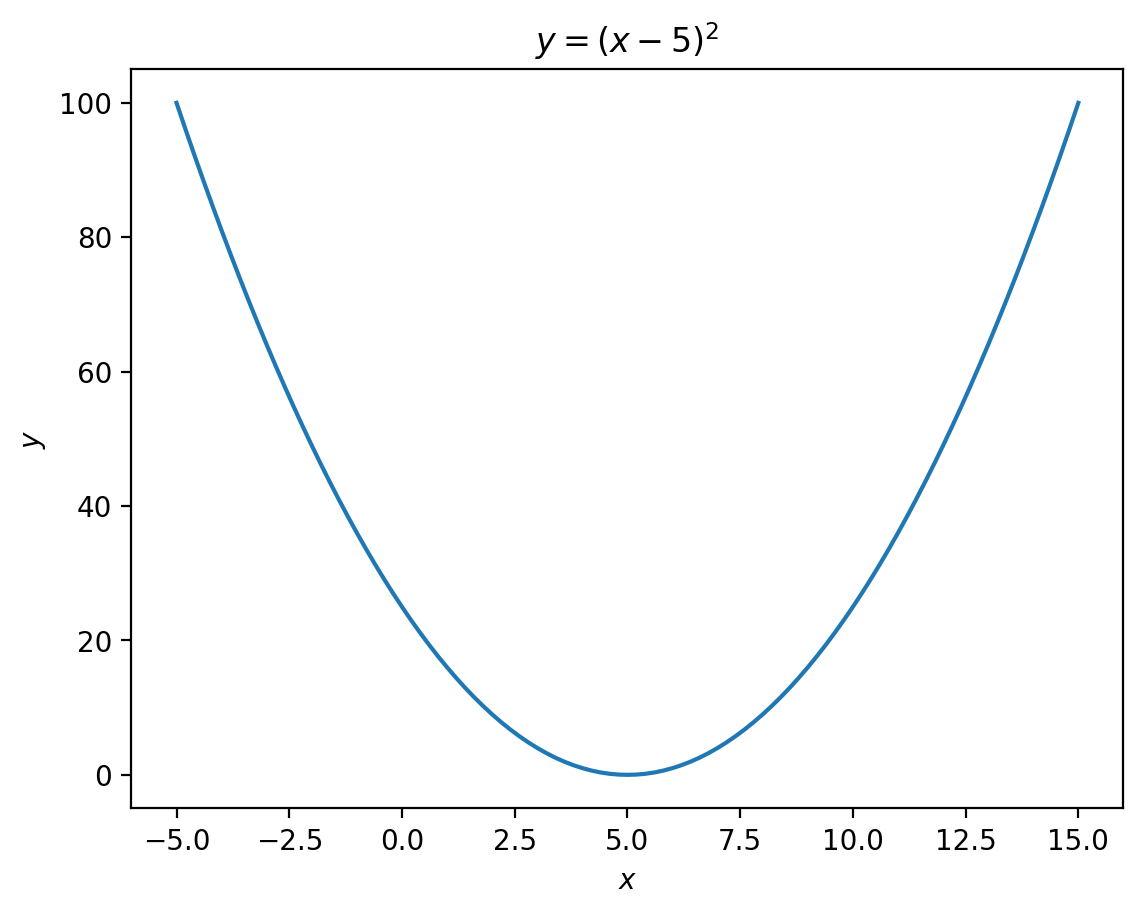

In [19]:
x = np.linspace(-5, 15, 101)
y = quadratic(x=x)
plt.plot(x, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'$y = (x - 5)^2$')
plt.show()

The minimum output of `quadratic()` occurs at $x=5$ if we do not use bounds or constraints, even if we start far away from $x=5$.

In [20]:
sco.minimize(
    fun=quadratic,
    x0=np.array([2001])
)

      fun: 2.0392713450495178e-16
 hess_inv: array([[0.5]])
      jac: array([-1.3659e-08])
  message: 'Optimization terminated successfully.'
     nfev: 18
      nit: 4
     njev: 9
   status: 0
  success: True
        x: array([5.])

The minimum output of `quadratic()` occurs at $x=6$ if we bound `x` between 6 and 10 (i.e., $6 \leq x \leq 10$).

In [21]:
sco.minimize(
    fun=quadratic,
    x0=np.array([2001]),
    bounds=((6, 10),)
)

      fun: 1.0
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([2.])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 4
      nit: 1
     njev: 2
   status: 0
  success: True
        x: array([6.])

The minimum output of `quadratic()` occurs at $x=6$, again, if we constrain `x - 6` to be non-negative.
We use bounds to limit the search space directly, and we use constraints to limit the search space indirectly based on a formula.

In [22]:
sco.minimize(
    fun=quadratic,
    x0=np.array([2001]),
    constraints=({'type': 'ineq', 'fun': lambda x: x - 6})
)

     fun: 1.0000000000000018
     jac: array([2.])
 message: 'Optimization terminated successfully'
    nfev: 6
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([6.])

We can use the `args=` argument to pass additional arguments to `fun`.
For example, we change the `a=` argument in `quadratic()` from the default of `a=5` to `a=20` with `args=(20,)`.
Note that `args=` expects a tuple, so we need a trailing comma `,` if we have one argument.

In [24]:
sco.minimize(
    fun=quadratic,
    args=(20,),
    x0=np.array([2001]),
)

      fun: 7.090392030754976e-17
 hess_inv: array([[0.5]])
      jac: array([-1.9397e-09])
  message: 'Optimization terminated successfully.'
     nfev: 18
      nit: 4
     njev: 9
   status: 0
  success: True
        x: array([20.])

### The Minimum Variance Portfolio

We can find the minimum variance portfolio with `minimize()` function from SciPy's `optimize` module.
The `minimize()` function with vary an input array `x` (starting from argument `x0=`) to minimize the objective function `fun=` subject to the bounds and constraints in `bounds=` and `constraints=`. 
We will define a function `port_vol()` to calculate portfolio volatility.
The first argument to `port_vol()` must be the input array `x` that the `minimize()` function searches over.
For clarity, we will call this first argument `x`, but the argument's name is not important.

In [25]:
def port_vol(x, r, ppy):
    return np.sqrt(ppy) * r.dot(x).std()

We will eventually need a mean portfolio return function, too.

In [26]:
def port_mean(x, r, ppy):
    return ppy * r.dot(x).mean()

In [28]:
res_mv = sco.minimize(
    fun=port_vol, # objective function that we minimize
    x0=np.ones(returns.shape[1]) / returns.shape[1], # initial portfolio weights
    args=(returns, 252), # additional arguments to our objective function
    bounds=[(0,1) for _ in returns], # bounds limit the search space for each portfolio weights
    constraints=(
        {'type': 'eq', 'fun': lambda x: x.sum() - 1} # minimize drives "eq" constraints to zero
    )
)

print(res_mv)

     fun: 0.28980781598721805
     jac: array([0.2903, 0.29  , 0.2894, 0.2897, 0.397 , 0.3458])
 message: 'Optimization terminated successfully'
    nfev: 56
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([3.0827e-01, 0.0000e+00, 2.3112e-01, 4.6061e-01, 7.4593e-17,
       0.0000e+00])


What are the attributes of this minimum variance portfolio?

In [29]:
def print_port_res(w, r, title, ppy=252, tgt=None):
    width = len(title)
    rp = r.dot(w)
    mu = ppy * rp.mean()
    sigma = np.sqrt(ppy) * rp.std()
    if tgt is not None:
        er = rp.sub(tgt)
        sr = np.sqrt(ppy) * er.mean() / er.std()
    else:
        sr = None
    
    return print(
        title,
        '=' * width,
        '',
        'Performance',
        '-' * width,
        'Return:'.ljust(width - 6) + f'{mu:0.4f}',
        'Volatility:'.ljust(width - 6) + f'{sigma:0.4f}',
        'Sharpe Ratio:'.ljust(width - 6) + f'{sr:0.4f}\n' if sr is not None else '',
        'Weights', 
        '-' * width, 
        '\n'.join([f'{_r}:'.ljust(width - 6) + f'{_w:0.4f}' for _r, _w in zip(r.columns, w)]),
        sep='\n',
    )

In [31]:
print_port_res(w=res_mv['x'], r=returns, title='Minimum Variance Portfolio')

Minimum Variance Portfolio

Performance
--------------------------
Return:             0.2984
Volatility:         0.2898

Weights
--------------------------
AAPL:               0.3083
AMZN:               0.0000
GOOG:               0.2311
MSFT:               0.4606
NVDA:               0.0000
TSLA:               0.0000


### The (Mean-Variance) Efficient Frontier

We will use the `minimize()` function to map the efficient frontier.
Here is a basic outline:

1. Create a NumPy array `tret` of target returns
1. Create an empty list `res_ef` of `minimize()` results
1. Loop over `tret`, passing each as a constraint to the `minimize()` function
1. Append each `minimize()` result to `res_ef`

In [33]:
tret = 252 * np.linspace(returns.mean().min(), returns.mean().max(), 25)

tret

array([0.076 , 0.1061, 0.1362, 0.1663, 0.1964, 0.2266, 0.2567, 0.2868,
       0.3169, 0.347 , 0.3772, 0.4073, 0.4374, 0.4675, 0.4976, 0.5277,
       0.5579, 0.588 , 0.6181, 0.6482, 0.6783, 0.7085, 0.7386, 0.7687,
       0.7988])

We will loop over these target returns, finding the minimum variance portfolio for each target return.

In [34]:
res_ef = []

for t in tret:
    _ = sco.minimize(
        fun=port_vol, # minimize portfolio volatility
        x0=np.ones(returns.shape[1]) / returns.shape[1], # initial portfolio weights
        args=(returns, 252), # additional arguments to fun, in order
        bounds=[(0, 1) for c in returns.columns], # bounds limit the search space for each portfolio weight
        constraints=(
            {'type': 'eq', 'fun': lambda x: x.sum() - 1}, # constrain sum of weights to one
            {'type': 'eq', 'fun': lambda x: port_mean(x=x, r=returns, ppy=252) - t} # constrains portfolio mean return to the target return

        )
    )
    res_ef.append(_)

List `res_ef` contains the results of all 25 minimum-variance portfolios.
For example, `res_ef[0]` is the minimum variance portfolio for the lowest target return.

In [35]:
res_ef[0]

     fun: 0.38644121151979843
     jac: array([0.2148, 0.3864, 0.2244, 0.2158, 0.3411, 0.3183])
 message: 'Optimization terminated successfully'
    nfev: 21
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([0.0000e+00, 1.0000e+00, 0.0000e+00, 2.9160e-11, 0.0000e+00,
       5.2856e-17])

I typically check that all portfolio volatility minimization succeeds.
If a portfolio volatility minimization fails, we should check our function, bounds, and constraints.

In [36]:
for r in res_ef:
    assert r['success'] 

We can combine the target returns and volatilities into a data frame `ef`.

In [37]:
ef = pd.DataFrame(
    {
        'tret': tret,
        'tvol': np.array([r['fun'] if r['success'] else np.nan for r in res_ef])
    }
)

ef.head()

,tret,tvol
0,0.0760,0.3864
1,0.1061,0.3609
2,0.1362,0.3388
3,0.1663,0.3207
4,0.1964,0.3073


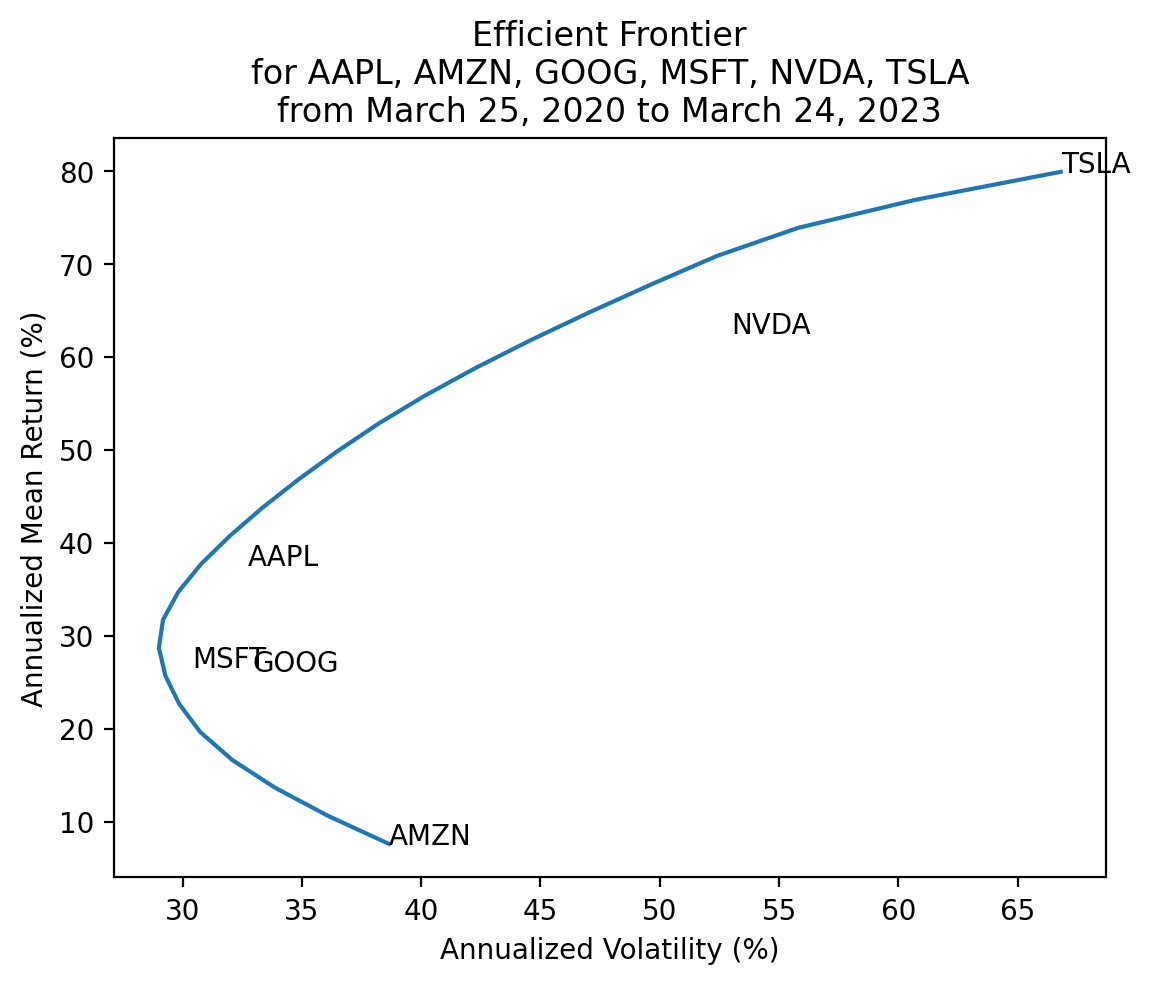

In [39]:
ef.mul(100).plot(x='tvol', y='tret', legend=False)
plt.ylabel('Annualized Mean Return (%)')
plt.xlabel('Annualized Volatility (%)')
plt.title(
    f'Efficient Frontier' +
    f'\nfor {", ".join(returns.columns)}' +
    f'\nfrom {returns.index[0]:%B %d, %Y} to {returns.index[-1]:%B %d, %Y}'
)

for t, x, y in zip(
    returns.columns, 
    returns.std().mul(100*np.sqrt(252)),
    returns.mean().mul(100*252)
):
    plt.annotate(text=t, xy=(x, y))
    
plt.show()

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
%config InlineBackend.figure_format = 'retina'
%precision 4
pd.options.display.float_format = '{:.4f}'.format

In [3]:
import yfinance as yf
import pandas_datareader as pdr
import requests_cache
session = requests_cache.CachedSession()

In [4]:
import scipy.optimize as sco

### Find the maximum Sharpe Ratio portfolio of MATANA stocks over the last three calendar years

***Note that `sco.minimize()` finds minimums, so we need to minimize the negative Sharpe Ratio.***

The following code downloads data for the MATANA stocks and assigns daily decimal returns from 2020 through 2022 to data frame `returns`.
We will stop in 2022 to make it easier to compare our results, whether we use the risk-free rate or value-weighted market portfolio as our benchmark or not.
Recall, the Fama and French benchmark factors are only available with a lag, and are only available through December 2022 as I type.

In [5]:
tickers = 'MSFT AAPL TSLA AMZN NVDA GOOG'

matana = (
    yf.download(tickers=tickers, progress=False)
    .assign(Date=lambda x: x.index.tz_localize(None))
    .set_index('Date')
    .rename_axis(columns=['Variable', 'Ticker'])
)

returns = matana['Adj Close'].pct_change().loc['2020':'2022']
returns.describe()

Ticker,AAPL,AMZN,GOOG,MSFT,NVDA,TSLA
count,756.0000,756.0000,756.0000,756.0000,756.0000,756.0000
mean,0.0011,0.0002,0.0006,0.0008,0.0018,0.0030
std,0.0233,0.0246,0.0217,0.0219,0.0352,0.0455
min,-0.1286,-0.1405,-0.1110,-0.1474,-0.1845,-0.2106
25%,-0.0110,-0.0129,-0.0097,-0.0097,-0.0177,-0.0215
50%,0.0006,0.0006,0.0012,0.0007,0.0029,0.0020
75%,0.0142,0.0123,0.0114,0.0123,0.0222,0.0251
max,0.1198,0.1354,0.0940,0.1422,0.1716,0.1989


In [6]:
def port_sharpe(x, r, tgt, ppy):
    rp = r.dot(x)
    er = rp.sub(tgt)
    return np.sqrt(ppy) * er.mean() / er.std()

In [7]:
def port_sharpe_neg(x, r, tgt, ppy):
    return -1 * port_sharpe(x, r, tgt, ppy)

In [8]:
def get_ew(r):
    return np.ones(r.shape[1]) / r.shape[1]

In [9]:
get_ew(returns)

array([0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667])

In [10]:
[(0, 1) for i in returns]

[(0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1)]

In [11]:
res_sharpe_1 = sco.minimize(
    fun=port_sharpe_neg,
    x0=get_ew(returns),
    args=(returns, 0, 252),
    bounds=[(0, 1) for i in returns],
    constraints=(
        {'type': 'eq', 'fun': lambda x: x.sum() - 1} # eq constraint met when equal to zero
    )
)

res_sharpe_1

     fun: -1.0891990431411531
     jac: array([ 1.1602e-04,  3.6243e-01,  1.1961e-01,  6.4995e-02,  4.9046e-04,
       -2.5962e-04])
 message: 'Optimization terminated successfully'
    nfev: 63
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([6.6101e-02, 2.5912e-17, 0.0000e+00, 0.0000e+00, 3.1307e-01,
       6.2083e-01])

In [12]:
port_sharpe(x=res_sharpe_1['x'], r=returns, tgt=0, ppy=252)

1.0891990431411531

### Find the maximum Sharpe Ratio portfolio of MATANA stocks over the last three years, but allow short weights up to 10% on each stock

In [13]:
res_sharpe_2 = sco.minimize(
    fun=port_sharpe_neg,
    x0=get_ew(returns),
    args=(returns, 0, 252),
    bounds=[(-0.1, 1.5) for i in returns],
    constraints=(
        {'type': 'eq', 'fun': lambda x: x.sum() - 1} # eq constraint met when equal to zero
    )
)

res_sharpe_2

     fun: -1.1368989996984662
     jac: array([0.041 , 0.3444, 0.1157, 0.0727, 0.041 , 0.041 ])
 message: 'Optimization terminated successfully'
    nfev: 63
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([ 0.2997, -0.1   , -0.1   , -0.1   ,  0.3745,  0.6258])

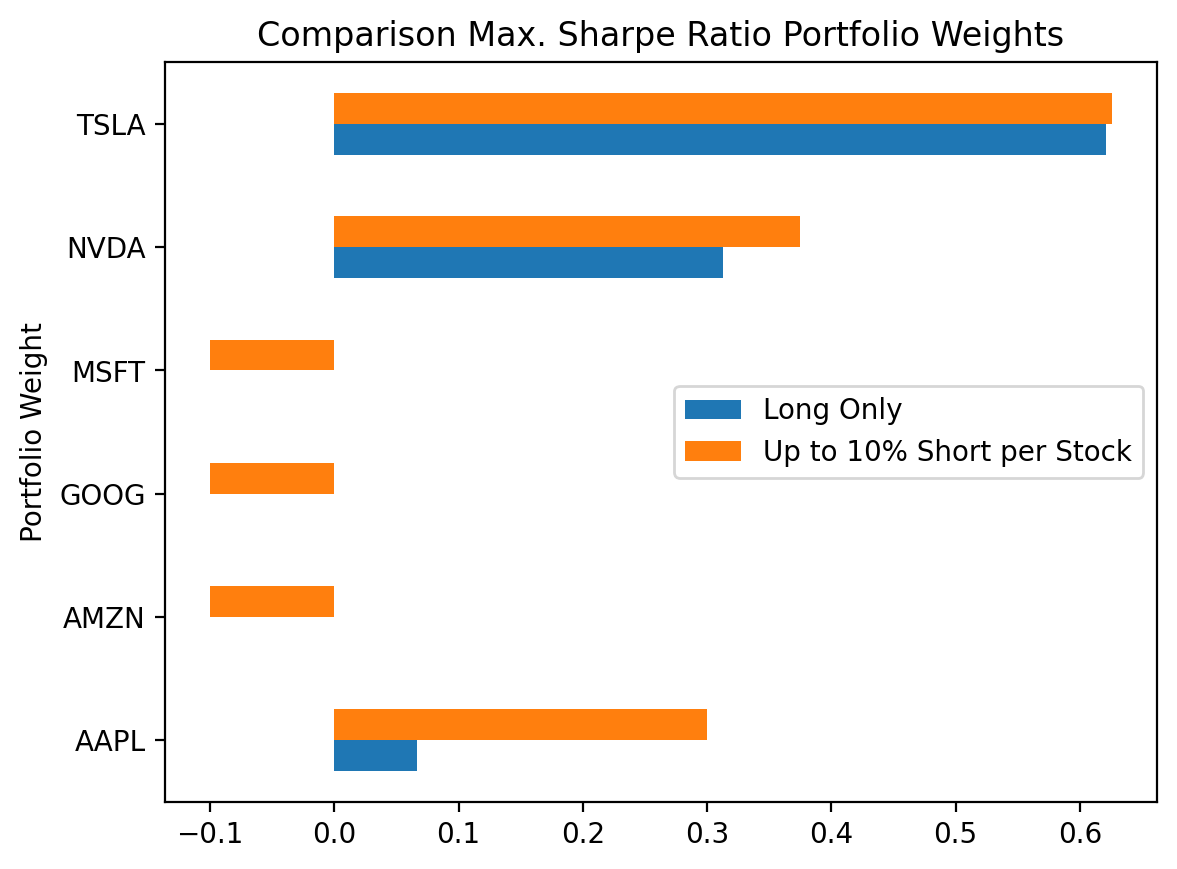

In [14]:
(
    pd.DataFrame(
        data={
            'Long Only':res_sharpe_1['x'], 
            'Up to 10% Short per Stock':res_sharpe_2['x']
        },
        index=returns.columns
    )
    .rename_axis('Portfolio Weight')
    .plot(kind='barh')
)
plt.title('Comparison Max. Sharpe Ratio Portfolio Weights')
plt.show()

By relaxing the long-only constrain (via changes to `bounds=`), the weights on AMZN, GOOG, and MSFT go from zero to -10%.
Also, the Sharpe Ratio increases because we relax a binding constraint.

In [15]:
port_sharpe(res_sharpe_1['x'], r=returns, tgt=0, ppy=252)

1.0891990431411531

In [16]:
port_sharpe(res_sharpe_2['x'], r=returns, tgt=0, ppy=252)

1.1368989996984662

### Find the maximum Sharpe Ratio portfolio of MATANA stocks over the last three years, but allow total short weights of up to 30%

We can find the negative values in a NumPy array as follows.

In [17]:
x = np.arange(6) - 3
x[x < 0]

array([-3, -2, -1])

In [18]:
res_sharpe_3 = sco.minimize(
    fun=port_sharpe_neg,
    x0=get_ew(returns),
    args=(returns, 0, 252),
    bounds=[(-0.3, 1.3) for i in returns],
    constraints=(
        {'type': 'eq', 'fun': lambda x: x.sum() - 1}, # eq constraint met when = 0
        {'type': 'ineq', 'fun': lambda x: x[x<0].sum() + 0.3} # ineq constraint met when >= 0
    )
)

res_sharpe_3

     fun: -1.1826810753664976
     jac: array([0.0782, 0.336 , 0.152 , 0.1096, 0.0773, 0.0773])
 message: 'Optimization terminated successfully'
    nfev: 100
     nit: 10
    njev: 10
  status: 0
 success: True
       x: array([ 3.5667e-01, -3.0000e-01, -1.7501e-09,  1.7759e-05,  3.4960e-01,
        5.9371e-01])

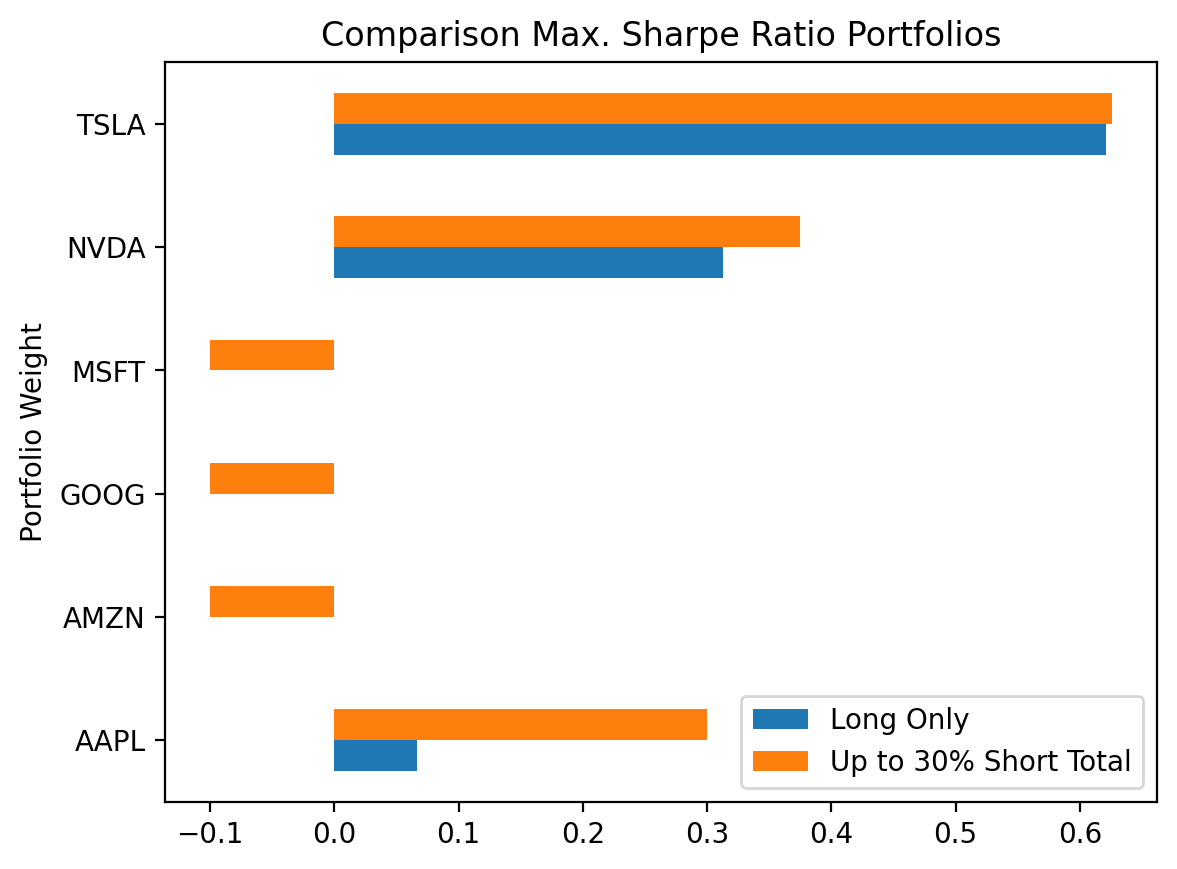

In [19]:
(
    pd.DataFrame(
        data={
            'Long Only':res_sharpe_1['x'], 
            'Up to 30% Short Total':res_sharpe_2['x']
        },
        index=returns.columns
    )
    .rename_axis('Portfolio Weight')
    .plot(kind='barh')
)
plt.title('Comparison Max. Sharpe Ratio Portfolios')
plt.show()

Again, by relaxing the long-only constrain, the weights on AMZN, GOOG, and MSFT go from zero to -10%.
Also, the Sharpe Ratio increases because we relax a binding constraints.
The Sharpe Ratio is higher here than in the previous exercise, but this will not always be the case, since we relax different constraints here and in the previous exercise.

In [20]:
port_sharpe(res_sharpe_1['x'], r=returns, ppy=252, tgt=0)

1.0891990431411531

In [21]:
port_sharpe(res_sharpe_3['x'], r=returns, ppy=252, tgt=0)

1.1826810753664976

### Find the maximum Sharpe Ratio portfolio of MATANA stocks over the last three years, but do not allow any weight to exceed 30% in magnitude

In [22]:
res_sharpe_4 = sco.minimize(
    fun=port_sharpe_neg,
    x0=np.ones(returns.shape[1]) / returns.shape[1],
    args=(returns, 252, 0),
    tol=1e-6,
    bounds=[(0,0.3) for _ in range(returns.shape[1])],
    constraints=(
        {'type': 'eq', 'fun': lambda x: x.sum() - 1}, # want eq constraint to = 0
    )
)

res_sharpe_4

     fun: 0.0
     jac: array([0., 0., 0., 0., 0., 0.])
 message: 'Optimization terminated successfully'
    nfev: 7
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667])

### Find the minimum 95% Value at Risk (Var) portfolio of MATANA stocks over the last three years

More on VaR [here](https://en.wikipedia.org/wiki/Value_at_risk).

In [23]:
def port_var(x, r, q):
    return r.dot(x).quantile(q)

In [24]:
def port_var_neg(x, r, q):
    return -1 * port_var(x=x, r=r, q=q)

In [25]:
res_var_1 = sco.minimize(
    fun=port_var_neg,
    x0=np.ones(returns.shape[1]) / returns.shape[1],
    args=(returns, 0.05),
    bounds=[(0,1) for _ in returns],
    constraints=(
        {'type': 'eq', 'fun': lambda x: x.sum() - 1}, # minimize drives "eq" constraints to zero
    )
)

res_var_1

     fun: 0.035922474334542105
     jac: array([0.0359, 0.0419, 0.037 , 0.0385, 0.0275, 0.0416])
 message: 'Optimization terminated successfully'
    nfev: 45
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([1.8180e-01, 1.4369e-01, 2.2517e-01, 2.4347e-01, 2.0587e-01,
       5.2421e-20])

In [26]:
port_var(x=res_var_1['x'], r=returns, q=0.05)

-0.035922474334542105

It might be helpful to slightly change then minimum VaR portfolio weights to show that we minimized VaR.

In [27]:
def tweak(x, d=0.05):
    y = np.zeros(x.shape[0])
    y[0], y[1] = d, -1 * d
    return x + y

In [28]:
port_var(x=tweak(res_var_1['x']), r=returns, q=0.05)

-0.036229546375465875

### Find the minimum maximum draw down portfolio of MATANA stocks over the last three years

In [29]:
def port_draw_down_max(x, r):
    rp = r.dot(x)
    price = rp.add(1).cumprod()
    cum_max = price.cummax()
    draw_down = (cum_max - price) / cum_max
    return draw_down.max()

In [30]:
res_dd_1 = sco.minimize(
    fun=port_draw_down_max,
    x0=np.ones(returns.shape[1]) / returns.shape[1],
    args=(returns,),
    bounds=[(0,1) for _ in returns],
    constraints=(
        {'type': 'eq', 'fun': lambda x: x.sum() - 1}, # minimize drives "eq" constraints to zero
    )
)

res_dd_1

     fun: 0.2973734368777809
     jac: array([0.2865, 0.5131, 0.4028, 0.2927, 0.5359, 0.7698])
 message: 'Optimization terminated successfully'
    nfev: 178
     nit: 20
    njev: 20
  status: 0
 success: True
       x: array([6.8104e-01, 9.6518e-18, 2.2588e-17, 3.1896e-01, 1.2995e-17,
       3.4603e-18])

In [31]:
port_draw_down_max(x=res_dd_1['x'], r=returns)

0.2974

Again. it might be helpful to slightly change then minimum VaR portfolio weights to show that we minimized VaR.

In [32]:
port_draw_down_max(x=tweak(res_dd_1['x']), r=returns)

0.3065

### Find the minimum maximum draw down portfolio with all available data for the current Dow-Jones Industrial Average (DJIA) stocks

You can find the [DJIA tickers on Wikipedia](https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average).

In [33]:
wiki = pd.read_html('https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average')
tickers = wiki[1]['Symbol'].to_list()

djia = (
    yf.download(tickers=tickers, progress=False)
    .assign(Date=lambda x: x.index.tz_localize(None))
    .set_index('Date')
    .rename_axis(columns=['Variable', 'Ticker'])
)

returns_2 = djia['Adj Close'].pct_change().loc['2020':'2022']
returns_2.describe()

Ticker,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,DOW,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
count,756.0000,756.0000,756.0000,756.0000,756.0000,756.0000,756.0000,756.0000,756.0000,756.0000,...,756.0000,756.0000,756.0000,756.0000,756.0000,756.0000,756.0000,756.0000,756.0000,756.0000
mean,0.0011,0.0004,0.0007,0.0000,0.0010,0.0001,0.0003,0.0011,-0.0004,0.0005,...,0.0006,0.0008,0.0005,0.0005,0.0007,0.0011,0.0004,-0.0003,-0.0002,0.0004
std,0.0233,0.0176,0.0286,0.0383,0.0224,0.0278,0.0199,0.0268,0.0241,0.0272,...,0.0161,0.0219,0.0238,0.0152,0.0210,0.0208,0.0211,0.0132,0.0231,0.0162
min,-0.1286,-0.0826,-0.1482,-0.2385,-0.1428,-0.1589,-0.1373,-0.2212,-0.1316,-0.2166,...,-0.0986,-0.1474,-0.1281,-0.0874,-0.2080,-0.1728,-0.1355,-0.0674,-0.1096,-0.1138
25%,-0.0110,-0.0080,-0.0130,-0.0173,-0.0106,-0.0137,-0.0085,-0.0108,-0.0123,-0.0124,...,-0.0073,-0.0097,-0.0104,-0.0060,-0.0087,-0.0080,-0.0099,-0.0061,-0.0104,-0.0067
50%,0.0006,-0.0003,0.0004,-0.0014,0.0010,0.0005,0.0000,0.0008,-0.0012,-0.0002,...,0.0000,0.0007,0.0000,0.0008,0.0017,0.0011,0.0007,-0.0002,-0.0007,0.0001
75%,0.0142,0.0081,0.0123,0.0152,0.0123,0.0149,0.0093,0.0133,0.0106,0.0142,...,0.0084,0.0123,0.0123,0.0075,0.0101,0.0095,0.0106,0.0054,0.0107,0.0077
max,0.1198,0.1090,0.2188,0.2432,0.1033,0.2604,0.1337,0.2274,0.1441,0.2091,...,0.0837,0.1422,0.1553,0.1201,0.1329,0.1280,0.1384,0.0721,0.1260,0.1171


In [34]:
res_dd_2 = sco.minimize(
    fun=port_draw_down_max,
    x0=np.ones(returns_2.shape[1]) / returns_2.shape[1],
    args=(returns_2,),
    bounds=[(0,1) for _ in returns_2],
    constraints=(
        {'type': 'eq', 'fun': lambda x: x.sum() - 1}, # minimize drives "eq" constraints to zero
    )
)

res_dd_2

     fun: 0.14526116917692314
     jac: array([0.1974, 0.064 , 0.2211, 0.2242, 0.1603, 0.0966, 0.162 , 0.1158,
       0.2333, 0.1664, 0.1609, 0.1217, 0.0695, 0.0094, 0.2134, 0.0657,
       0.1275, 0.0835, 0.0717, 0.1171, 0.0113, 0.1175, 0.1914, 0.1776,
       0.0756, 0.1588, 0.1089, 0.0882, 0.1333, 0.2522])
 message: 'Optimization terminated successfully'
    nfev: 879
     nit: 27
    njev: 27
  status: 0
 success: True
       x: array([8.5088e-17, 2.6650e-02, 0.0000e+00, 1.9963e-17, 4.8467e-17,
       4.6527e-18, 1.4882e-17, 5.6870e-17, 1.4465e-16, 1.0899e-16,
       1.6653e-18, 2.1579e-18, 4.2017e-17, 3.0508e-17, 7.0291e-17,
       1.3723e-01, 3.8140e-17, 3.8649e-17, 2.6616e-17, 4.6360e-17,
       1.9045e-01, 1.3055e-01, 7.8858e-17, 1.1369e-18, 2.2045e-18,
       2.0718e-17, 1.0429e-17, 1.2647e-01, 9.0356e-17, 3.8864e-01])

In [35]:
port_draw_down_max(x=res_dd_2['x'], r=returns_2)

0.1453

Again. it might be helpful to slightly change then minimum VaR portfolio weights to show that we minimized VaR.

In [36]:
port_draw_down_max(x=tweak(res_dd_2['x']), r=returns_2)

0.1519

### Plot the (mean-variance) efficient frontier with all available data for the current the DJIA stocks

The range of target returns in `tret` span from the minimum to the maximum mean single-stock returns.

In [37]:
_ = returns_2.mean().mul(252)
tret = np.linspace(_.min(), _.max(), 25)

We will loop over these target returns, finding the minimum variance portfolio for each target return.

In [38]:
def port_vol(x, r, ppy):
    return np.sqrt(ppy) * r.dot(x).std()

In [39]:
def port_mean(x, r, ppy):
    return ppy * r.dot(x).mean()

In [40]:
res_ef = []

for t in tret:
    _ = sco.minimize(
        fun=port_vol, # minimize portfolio volatility
        x0=np.ones(returns_2.shape[1]) / returns_2.shape[1], # initial portfolio weights
        args=(returns_2, 252), # additional arguments to fun, in order
        bounds=[(0, 1) for c in returns_2.columns], # bounds limit the search space for each portfolio weight
        constraints=(
            {'type': 'eq', 'fun': lambda x: x.sum() - 1}, # constrain sum of weights to one
            {'type': 'eq', 'fun': lambda x: port_mean(x=x, r=returns_2, ppy=252) - t} # constrains portfolio mean return to the target return

        )
    )
    res_ef.append(_)

List `res_ef` contains the results of all 25 minimum-variance portfolios.
For example, `res_ef[0]` is the minimum variance portfolio for the lowest target return.

In [41]:
res_ef[0]

     fun: 0.42060231866698816
     jac: array([0.226 , 0.1289, 0.2273, 0.2753, 0.1603, 0.2102, 0.1879, 0.1846,
       0.1792, 0.1971, 0.2016, 0.1831, 0.1662, 0.1612, 0.4206, 0.0915,
       0.1934, 0.1133, 0.122 , 0.1283, 0.0833, 0.2267, 0.1728, 0.1111,
       0.1504, 0.1597, 0.1808, 0.0838, 0.154 , 0.0955])
 message: 'Optimization terminated successfully'
    nfev: 62
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([0.0000e+00, 2.3870e-15, 4.9336e-15, 1.2490e-16, 5.4123e-16,
       9.8532e-16, 0.0000e+00, 0.0000e+00, 1.2915e-07, 0.0000e+00,
       0.0000e+00, 2.1858e-15, 0.0000e+00, 0.0000e+00, 1.0000e+00,
       0.0000e+00, 0.0000e+00, 1.2282e-15, 7.4246e-16, 2.4980e-15,
       1.0408e-15, 0.0000e+00, 2.2204e-16, 3.0531e-16, 1.2906e-15,
       0.0000e+00, 0.0000e+00, 2.4980e-16, 0.0000e+00, 0.0000e+00])

I typically check that all portfolio volatility minimization succeeds.
If a portfolio volatility minimization fails, we should check our function, bounds, and constraints.

In [42]:
for r in res_ef:
    assert r['success'] 

We can combine the target returns and volatilities into a data frame `ef`.

In [43]:
ef = pd.DataFrame(
    {
        'tret': tret,
        'tvol': np.array([r['fun'] if r['success'] else np.nan for r in res_ef])
    }
)

ef.head()

,tret,tvol
0,-0.1535,0.4206
1,-0.1358,0.3435
2,-0.1181,0.2757
3,-0.1004,0.2253
4,-0.0827,0.2027


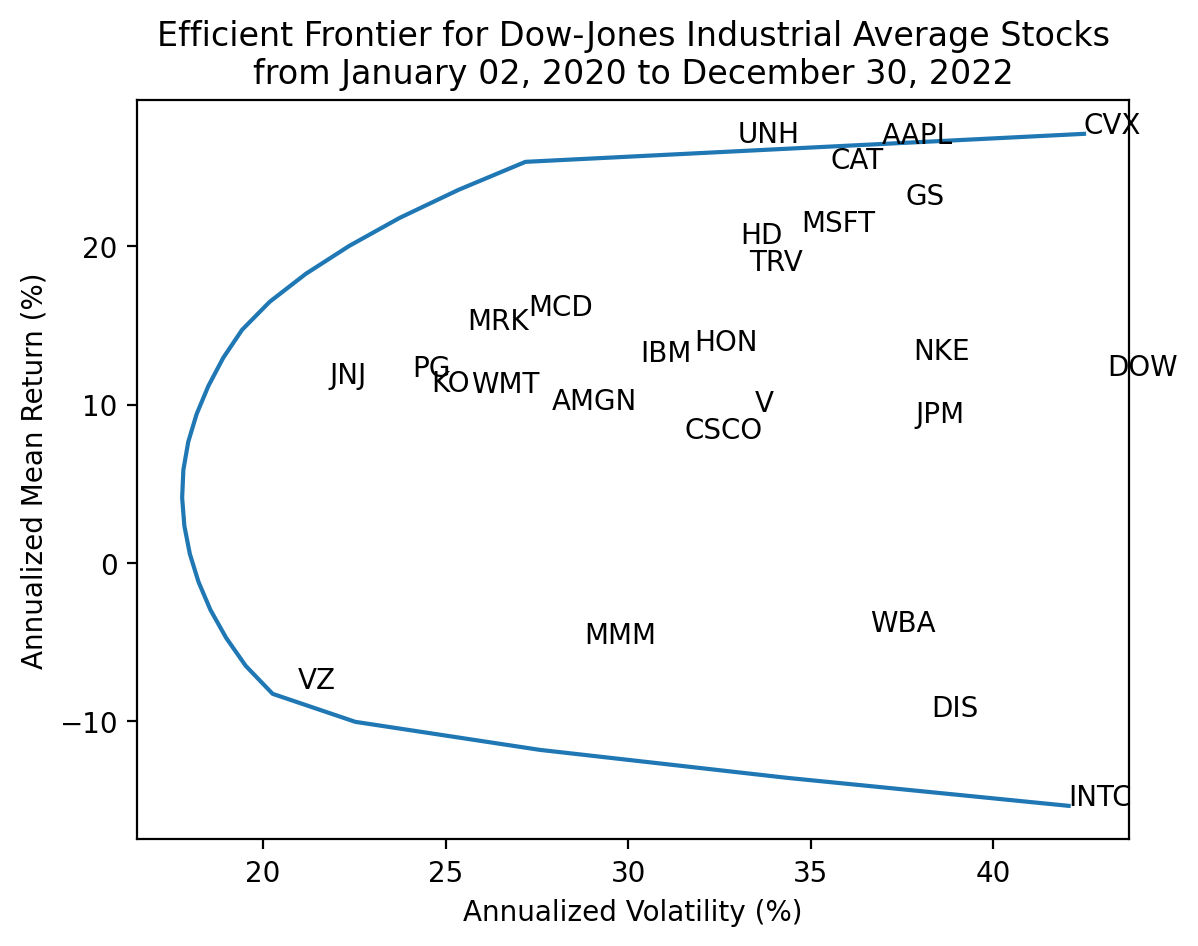

In [44]:
ef.mul(100).plot(x='tvol', y='tret', legend=False)
plt.ylabel('Annualized Mean Return (%)')
plt.xlabel('Annualized Volatility (%)')
plt.title(
    f'Efficient Frontier for Dow-Jones Industrial Average Stocks' +
    f'\nfrom {returns_2.index[0]:%B %d, %Y} to {returns_2.index[-1]:%B %d, %Y}'
)

for t, x, y in zip(
    returns_2.columns, 
    returns_2.std().mul(100*np.sqrt(252)),
    returns_2.mean().mul(100*252)
):
    plt.annotate(text=t, xy=(x, y))
    
plt.show()

### Find the maximum Sharpe Ratio portfolio with all available data for the current the DJIA stocks

In [45]:
res_sharpe_6 = sco.minimize(
    fun=port_sharpe_neg,
    x0=np.ones(returns_2.shape[1]) / returns_2.shape[1],
    args=(returns_2, 252, 0),
    bounds=[(0,1) for _ in range(returns_2.shape[1])],
    constraints=(
        {'type': 'eq', 'fun': lambda x: x.sum() - 1} # want eq constraint to = 0
    )
)

In [46]:
port_sharpe(x=res_sharpe_6['x'], r=returns_2, ppy=252, tgt=0)

0.4419167465321825

### Compare the $\frac{1}{n}$ and maximum Sharpe Ratio portfolios with all available data for the current DJIA stocks

Use all but the last 252 trading days to estimate the maximum Sharpe Ratio portfolio weights.
Then use the last 252 trading days of data to compare the $\frac{1}{n}$  maximum Sharpe Ratio portfolios.

In [47]:
res_sharpe_x = sco.minimize(
    fun=port_sharpe_neg,
    x0=get_ew(returns_2),
    args=(returns_2.loc['2020':'2021'], 0, 252),
    bounds=[(0, 1) for i in returns_2],
    constraints=(
        {'type': 'eq', 'fun': lambda x: x.sum() - 1} # eq constraint met when equal to zero
    )
)

res_sharpe_x

     fun: -1.451019869956015
     jac: array([-3.3244e-05,  7.1544e-01,  3.6336e-01,  1.5581e+00, -5.4896e-05,
        2.6187e-01,  3.1877e-01,  6.4522e-01,  6.0754e-01,  5.1480e-01,
        2.2540e-02, -2.8297e-05,  4.4621e-01,  4.4353e-01,  1.1298e+00,
        2.2024e-01,  4.9128e-01,  3.9944e-01,  2.4492e-01,  4.7485e-01,
        6.0061e-01,  3.6570e-04, -1.0264e-03,  1.1015e-01,  4.1630e-01,
        1.2804e-02,  6.8370e-01,  5.0606e-01,  5.0418e-01,  1.4876e-01])
 message: 'Optimization terminated successfully'
    nfev: 218
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([5.1283e-01, 7.3929e-17, 0.0000e+00, 0.0000e+00, 1.0011e-02,
       6.1795e-16, 1.2347e-15, 0.0000e+00, 0.0000e+00, 4.7353e-16,
       3.4684e-16, 2.5709e-01, 0.0000e+00, 4.1536e-16, 0.0000e+00,
       5.3411e-17, 2.8629e-16, 6.5371e-17, 8.9074e-17, 2.4575e-16,
       8.2074e-17, 1.7922e-01, 4.0854e-02, 3.3561e-16, 2.8254e-16,
       3.0830e-16, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00])

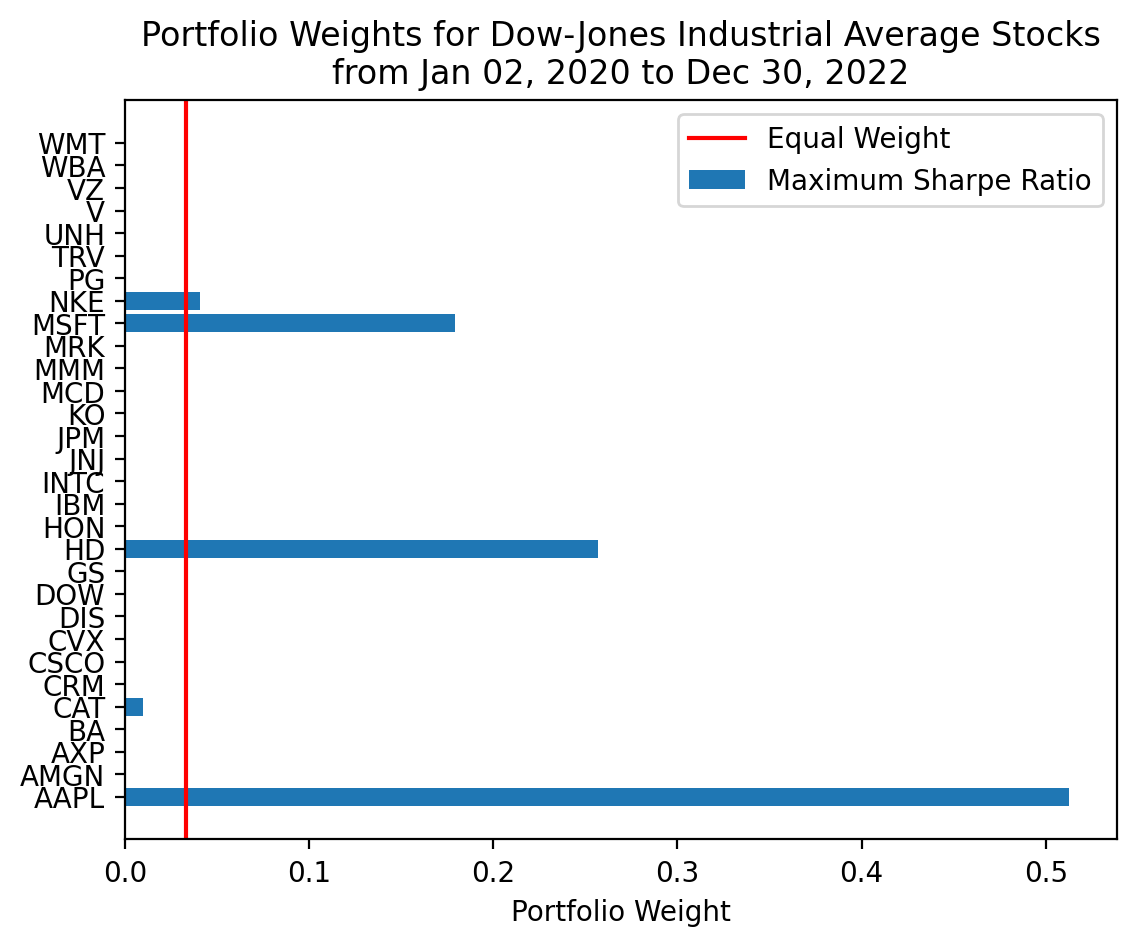

In [48]:
plt.barh(
    y=returns_2.columns,
    width=res_sharpe_x['x'],
    label='Maximum Sharpe Ratio'
)
plt.axvline(1/30, color='red', label='Equal Weight')
plt.legend()
plt.xlabel('Portfolio Weight')
plt.title(
    'Portfolio Weights for Dow-Jones Industrial Average Stocks' +
    f'\nfrom {returns_2.index[0]:%b %d, %Y} to {returns_2.index[-1]:%b %d, %Y}'
)
plt.show()

In [49]:
port_sharpe(res_sharpe_x['x'], returns_2.loc['2022'], 0, 252)

-0.7530020412398378

In [50]:
port_sharpe(get_ew(returns_2), returns_2.loc['2022'], 0, 252)

-0.25436549146826076

It is hard to beat the $\frac{1}{n}$ portfolio because mean returns (and covariances) are hard to predict!

---

Side discussion on the `.dot()` method.

In [51]:
weights = get_ew(returns)

In [52]:
np.allclose(
    weights.dot(returns.transpose()),
    returns.dot(weights)
)

True

In [53]:
np.allclose(
    returns @ weights,
    returns.dot(weights)
)

True

In [54]:
np.allclose(
    weights @ returns.transpose(),
    returns.dot(weights)
)

True